In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd

In [2]:
from data import *
from net import *

In [3]:
os.getcwd()

'C:\\Users\\minha\\Github\\signaling-systems\\trajectories'

In [4]:
data_path = 'D:\\Data\\hoffmanlab\\lstmtimeseries\\data2\\'

In [5]:
files = os.listdir('D:\\Data\\hoffmanlab\\lstmtimeseries\\data2')

## Todo:
- Visualization Functions?
- StandardScaler?

In [6]:
nfkb_path = files[8:]
nfkb_path = [[nfkb_path[i], nfkb_path[i+1]] for i in range(0, 8, 2)]

In [7]:
ktr_path = files[:8]
ktr_path = [[ktr_path[i], ktr_path[i+1]] for i in range(0, 8, 2)]

In [8]:
dataset = NFkBKTR_Dataset(nfkb_path, ktr_path, data_path, remove_nans=True)

In [9]:
print(len(dataset) * 0.9, len(dataset) * 0.1)

3609.0 401.0


In [164]:
dataset.data = scaled_data

In [165]:
train, val = torch.utils.data.random_split(dataset, [3609, 401])

trainloader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=64)
valloader = torch.utils.data.DataLoader(val, shuffle=True, batch_size=64)

In [166]:
device = torch.device('cuda:0')

model = TSC_1(
    input_dim=2,
    hidden_dim=95,
    output_dim=4,
    num_layers=2,
    linear_hidden_dim=512
).to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

## Training Loop

In [167]:
avg_train_loss_2, avg_val_loss_2, avg_acc_2 = [], [], []

In [168]:
top_acc = 0

for e in range(300):
    train_loss, val_loss = [], []
    for x, y in trainloader:
        x, y = x.float().to(device), y.long().to(device)
        pred = model(x)
        l = loss(pred, y)
        
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        
        train_loss.append(l.detach().cpu().numpy())
    
    acc_list = []
    for x, y in valloader:
        x, y = x.float().to(device), y.long().to(device)
        pred = model(x)
        l = loss(pred, y)
        
        val_loss.append(l.detach().cpu().numpy())
        
        # calculate accuracy
        acc = sum(torch.argmax(F.softmax(pred, dim=1), dim=1) == y) / len(y)
        acc = acc.detach().cpu().numpy()
        if acc > top_acc:
            top_acc = acc
        acc_list.append(acc)
    
    avg_train_loss_2.append(np.mean(train_loss))
    avg_val_loss_2.append(np.mean(val_loss))
    avg_acc_2.append(np.mean(acc_list))
    
    if e % 10 == 0:
        print(f'Epoch: {e}, Train Loss: {np.mean(avg_train_loss_2)}, Val Loss: {np.mean(avg_val_loss_2)}, Acc: {np.mean(avg_acc_2)}, Top Acc: {top_acc}')

Epoch: 0, Train Loss: 1.3052719831466675, Val Loss: 1.2588768005371094, Acc: 0.3696165978908539, Top Acc: 0.46875
Epoch: 10, Train Loss: 1.228621244430542, Val Loss: 1.1823629140853882, Acc: 0.47087475657463074, Top Acc: 0.7058823704719543
Epoch: 20, Train Loss: 1.197882890701294, Val Loss: 1.1606638431549072, Acc: 0.47904786467552185, Top Acc: 0.7058823704719543
Epoch: 30, Train Loss: 1.0826668739318848, Val Loss: 1.0352503061294556, Acc: 0.5378279089927673, Top Acc: 0.8823529481887817
Epoch: 40, Train Loss: 0.9738555550575256, Val Loss: 0.9357381463050842, Acc: 0.5862913727760315, Top Acc: 0.9411764740943909
Epoch: 50, Train Loss: 0.8922575116157532, Val Loss: 0.8645603060722351, Acc: 0.6208523511886597, Top Acc: 0.9411764740943909
Epoch: 60, Train Loss: 0.828593373298645, Val Loss: 0.8120293021202087, Acc: 0.6467983722686768, Top Acc: 0.9411764740943909
Epoch: 70, Train Loss: 0.7754387855529785, Val Loss: 0.7729325890541077, Acc: 0.6672442555427551, Top Acc: 0.9411764740943909
Epoch

KeyboardInterrupt: 

In [34]:
import matplotlib.pyplot as plt

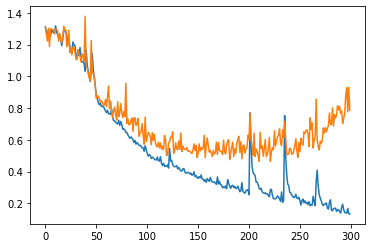

In [44]:
plt.plot(avg_train_loss)
plt.plot(avg_val_loss)

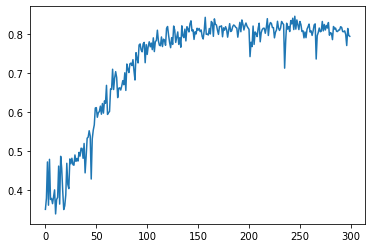

In [47]:
plt.plot(avg_acc)

In [48]:
np.max(avg_acc)

0.8448004

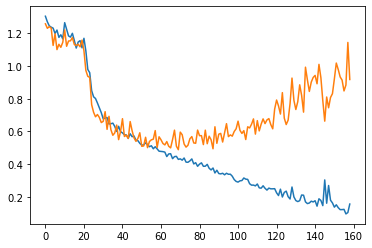

In [169]:
plt.plot(avg_train_loss_2)
plt.plot(avg_val_loss_2)

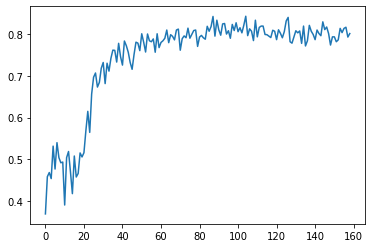

In [170]:
plt.plot(avg_acc_2)

## Evaluation
- For model trained on both replicas, will perform evaluation on the validation set
- For model trained on one replica, will use the other replica as the test set

In [71]:
y_pred = []
y_target = []

for x, y in valloader:
    x, y = x.float().to(device), y.long().to(device)
    pred = model(x)
    
    pred = torch.argmax(F.softmax(pred, dim=1), dim=1).detach().cpu().numpy()
    target = y.detach().cpu().numpy()
    
    y_pred.append(pred)
    y_target.append(target)

In [72]:
all_pred, all_target = np.concatenate(y_pred), np.concatenate(y_target)

In [73]:
print(f'Accuracy: {sum(all_pred == all_target) / len(all_pred)}')

Accuracy: 0.7830423940149626


In [74]:
import sklearn.metrics

In [78]:
confusion_matrix = sklearn.metrics.confusion_matrix(all_target, all_pred)
cmd = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix,
    display_labels=['CpG', 'LPS', 'P3C4', 'TNF']
)

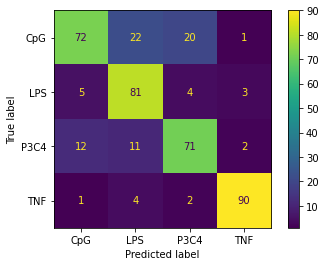

In [79]:
cmd.plot()

In [80]:
# weaker differentation for CpG and P3C4
# perfect classifaction of TNF (as expected), relatively stronger classification for LPS

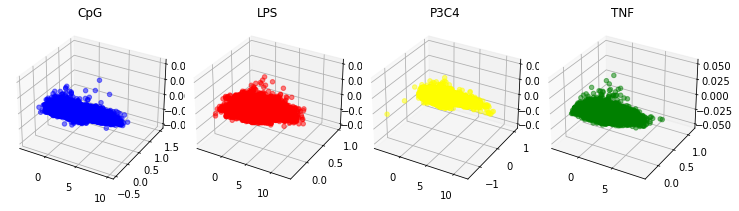

In [113]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 4, 1, projection='3d', title='CpG')
ax.scatter3D(
    xs = dataset.data[0:1146, :, 0],
    ys = dataset.data[0:1146, :, 1],
    alpha=0.5,
    c='blue'
)

ax = fig.add_subplot(1, 4, 2, projection='3d', title='LPS')
ax.scatter3D(
    xs = dataset.data[1146:2097, :, 0],
    ys = dataset.data[1146:2097, :, 1],
    alpha=0.5,
    c='red'
)

ax = fig.add_subplot(1, 4, 3, projection='3d', title='P3C4')
ax.scatter3D(
    xs = dataset.data[2097:2976, :, 0],
    ys = dataset.data[2097:2976, :, 1],
    alpha=0.5,
    c='yellow'
)

ax = fig.add_subplot(1, 4, 4, projection='3d', title='TNF')
ax.scatter3D(
    xs = dataset.data[2976:, :, 0],
    ys = dataset.data[2976:, :, 1],
    alpha=0.5,
    c='green'
)

plt.tight_layout()

In [138]:
np.mean(dataset.data[0:1146, :, 0], axis=0).shape

(95,)

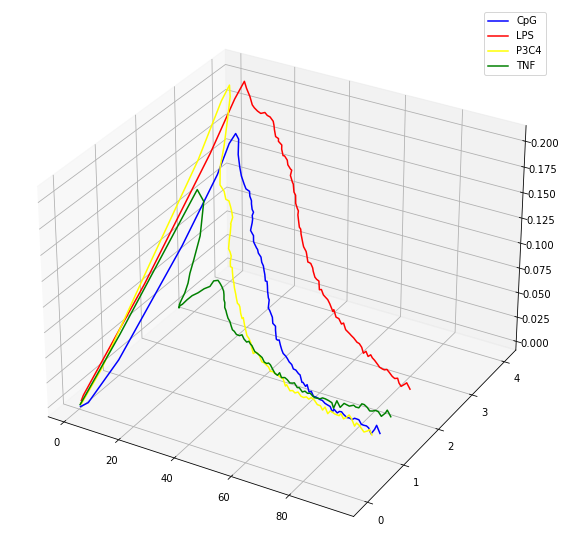

In [145]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.plot(
    xs = np.linspace(1, 95, 95),
    ys = np.mean(dataset.data[0:1146, :, 0], axis=0),
    zs = np.mean(dataset.data[0:1146, :, 1], axis=0),
    label='CpG',
    c='blue'
)

ax.plot(
    xs = np.linspace(1, 95, 95),
    ys = np.mean(dataset.data[1146:2097, :, 0], axis=0),
    zs = np.mean(dataset.data[1146:2097, :, 1], axis=0),
    label='LPS',
    c='red'
)

ax.plot(
    xs = np.linspace(1, 95, 95),
    ys = np.mean(dataset.data[2097:2976, :, 0], axis=0),
    zs = np.mean(dataset.data[2097:2976, :, 1], axis=0),
    label='P3C4',
    c='yellow'
)

ax.plot(
    xs = np.linspace(1, 95, 95),
    ys = np.mean(dataset.data[2976:, :, 0], axis=0),
    zs = np.mean(dataset.data[2976:, :, 1], axis=0),
    label='TNF',
    c='green'
)

plt.legend()

In [146]:
# the trajectories of CpG, LPS, P3C4 follow similar paths while TNF differentiates noticeably more

In [152]:
sep

[1146, 2097, 2976]

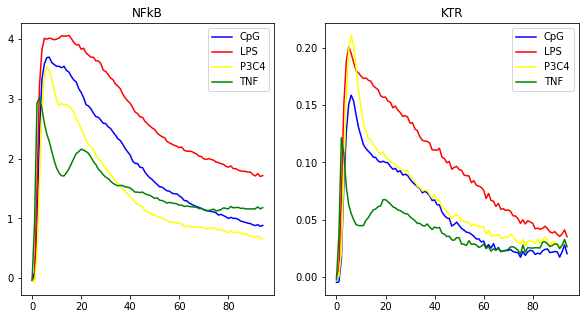

In [161]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# NFkB
ax[0].plot(np.mean(dataset.data[:1146, :, 0], axis=0), label='CpG', c='blue')
ax[0].plot(np.mean(dataset.data[1146:2097, :, 0], axis=0), label='LPS', c='red')
ax[0].plot(np.mean(dataset.data[2097:2976, :, 0], axis=0), label='P3C4', c='yellow')
ax[0].plot(np.mean(dataset.data[2976:, :, 0], axis=0), label='TNF', c='green')
ax[0].set_title('NFkB')
ax[0].legend()

# KTR
ax[1].plot(np.mean(dataset.data[:1146, :, 1], axis=0), label='CpG', c='blue')
ax[1].plot(np.mean(dataset.data[1146:2097, :, 1], axis=0), label='LPS', c='red')
ax[1].plot(np.mean(dataset.data[2097:2976, :, 1], axis=0), label='P3C4', c='yellow')
ax[1].plot(np.mean(dataset.data[2976:, :, 1], axis=0), label='TNF', c='green')
ax[1].set_title('KTR')
ax[1].legend()

## Standard Scaled Data

In [148]:
import copy
import sklearn.preprocessing 

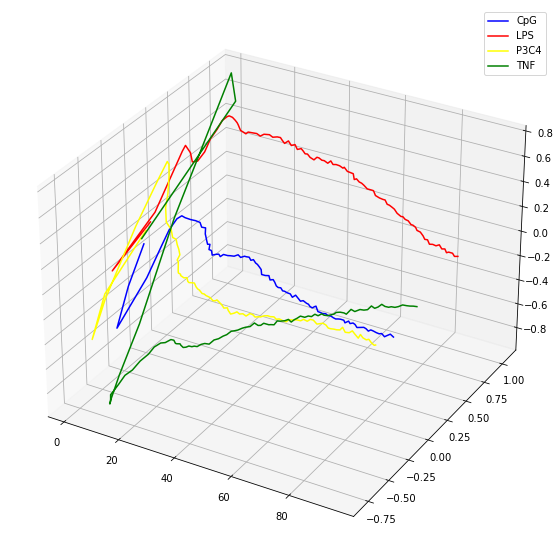

In [151]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

scaled_data = dataset.data.copy()
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(scaled_data[:, :, 0])
scaled_data[:, :, 0] = scaler.transform(scaled_data[:, :, 0])
scaler.fit(scaled_data[:, :, 1])
scaled_data[:, :, 1] = scaler.transform(scaled_data[:, :, 1])

ax.plot(
    xs = np.linspace(1, 95, 95),
    ys = np.mean(scaled_data[0:1146, :, 0], axis=0),
    zs = np.mean(scaled_data[0:1146, :, 1], axis=0),
    label='CpG',
    c='blue'
)

ax.plot(
    xs = np.linspace(1, 95, 95),
    ys = np.mean(scaled_data[1146:2097, :, 0], axis=0),
    zs = np.mean(scaled_data[1146:2097, :, 1], axis=0),
    label='LPS',
    c='red'
)

ax.plot(
    xs = np.linspace(1, 95, 95),
    ys = np.mean(scaled_data[2097:2976, :, 0], axis=0),
    zs = np.mean(scaled_data[2097:2976, :, 1], axis=0),
    label='P3C4',
    c='yellow'
)

ax.plot(
    xs = np.linspace(1, 95, 95),
    ys = np.mean(scaled_data[2976:, :, 0], axis=0),
    zs = np.mean(scaled_data[2976:, :, 1], axis=0),
    label='TNF',
    c='green'
)

plt.legend()

In [ ]:
# trajectories have significantly more variance after scaling

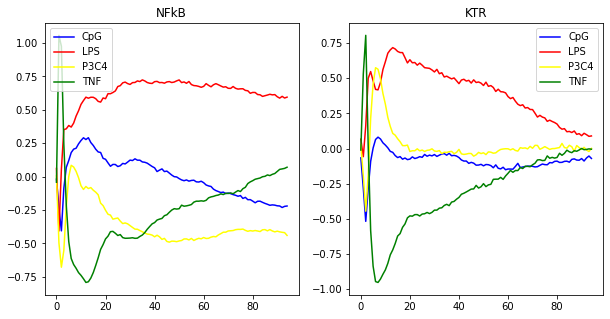

In [163]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# NFkB
ax[0].plot(np.mean(scaled_data[:1146, :, 0], axis=0), label='CpG', c='blue')
ax[0].plot(np.mean(scaled_data[1146:2097, :, 0], axis=0), label='LPS', c='red')
ax[0].plot(np.mean(scaled_data[2097:2976, :, 0], axis=0), label='P3C4', c='yellow')
ax[0].plot(np.mean(scaled_data[2976:, :, 0], axis=0), label='TNF', c='green')
ax[0].set_title('NFkB')
ax[0].legend()

# KTR
ax[1].plot(np.mean(scaled_data[:1146, :, 1], axis=0), label='CpG', c='blue')
ax[1].plot(np.mean(scaled_data[1146:2097, :, 1], axis=0), label='LPS', c='red')
ax[1].plot(np.mean(scaled_data[2097:2976, :, 1], axis=0), label='P3C4', c='yellow')
ax[1].plot(np.mean(scaled_data[2976:, :, 1], axis=0), label='TNF', c='green')
ax[1].set_title('KTR')
ax[1].legend()

In [171]:
y_pred = []
y_target = []

for x, y in valloader:
    x, y = x.float().to(device), y.long().to(device)
    pred = model(x)
    
    pred = torch.argmax(F.softmax(pred, dim=1), dim=1).detach().cpu().numpy()
    target = y.detach().cpu().numpy()
    
    y_pred.append(pred)
    y_target.append(target)

In [172]:
all_pred, all_target = np.concatenate(y_pred), np.concatenate(y_target)

In [173]:
print(f'Accuracy: {sum(all_pred == all_target) / len(all_pred)}')

Accuracy: 0.8079800498753117


In [174]:
confusion_matrix = sklearn.metrics.confusion_matrix(all_target, all_pred)
cmd = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix,
    display_labels=['CpG', 'LPS', 'P3C4', 'TNF']
)

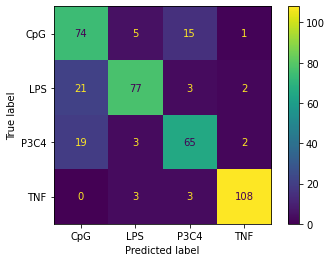

In [175]:
cmd.plot()

## Scaled vs Unscaled Data
- Model trains significantly faster i.e learns to differentiate different ligands in ~1/2 the epochs when trained on scaled data vs unscaled data
- Performance is approximately the same (overfits faster), best accuracies are similar across both models
- Scaling the data improves training speed, but has relatively marginal effects on overall classification power

In [162]:
torch.save({
    'weights': model.state_dict(),
    'optimizer': optimizer.state_dict()
}, 'weights/1_2d.pth')

In [100]:
sep = []
for i in range(len(dataset.labels) - 1):
    if dataset.labels[i] != dataset.labels[i + 1]:
        sep.append(i + 1)

In [101]:
sep

[1146, 2097, 2976]